In [116]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from skimage.io import imread
import random
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

* Kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [117]:
def loading_data(train_or_test_set) :
    
    # Define path to the data directory
    data_dir = Path('dataset') / train_or_test_set
    
    # Get the path to the normal and pneumonia sub-directories
    normal_cases_dir = data_dir / 'NORMAL'
    pneumonia_cases_dir = data_dir / 'PNEUMONIA'
    
    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    
    # Firstly, let data be an empty list.
    # We will insert the data into this list in (img_path, label) format.
    # Go through all the normal cases. The label for these cases will be 0.
    # Go through all the pneumonia cases. The label for these cases will be 1.
    data = []
    [data.append(((img, np.zeros(1)))) for img in normal_cases]
    [data.append(((img, np.ones(1)))) for img in pneumonia_cases]
    df = pd.DataFrame(data, columns = ['image', 'label'], index = None)
    
    if train_or_test_set == 'training_set' :
        # Take 500 observations for each class
        df = pd.concat([df.head(500), df.tail(500)], axis=0)
    
    return df

In [118]:
df_train = loading_data(train_or_test_set = 'training_set')
df_train.head()

,image,label
0,dataset/training_set/NORMAL/NORMAL2-IM-1266-00...,[0.0]
1,dataset/training_set/NORMAL/NORMAL2-IM-1201-00...,[0.0]
2,dataset/training_set/NORMAL/IM-0211-0001.jpeg,[0.0]
3,dataset/training_set/NORMAL/IM-0656-0001-0002....,[0.0]
4,dataset/training_set/NORMAL/IM-0364-0001.jpeg,[0.0]


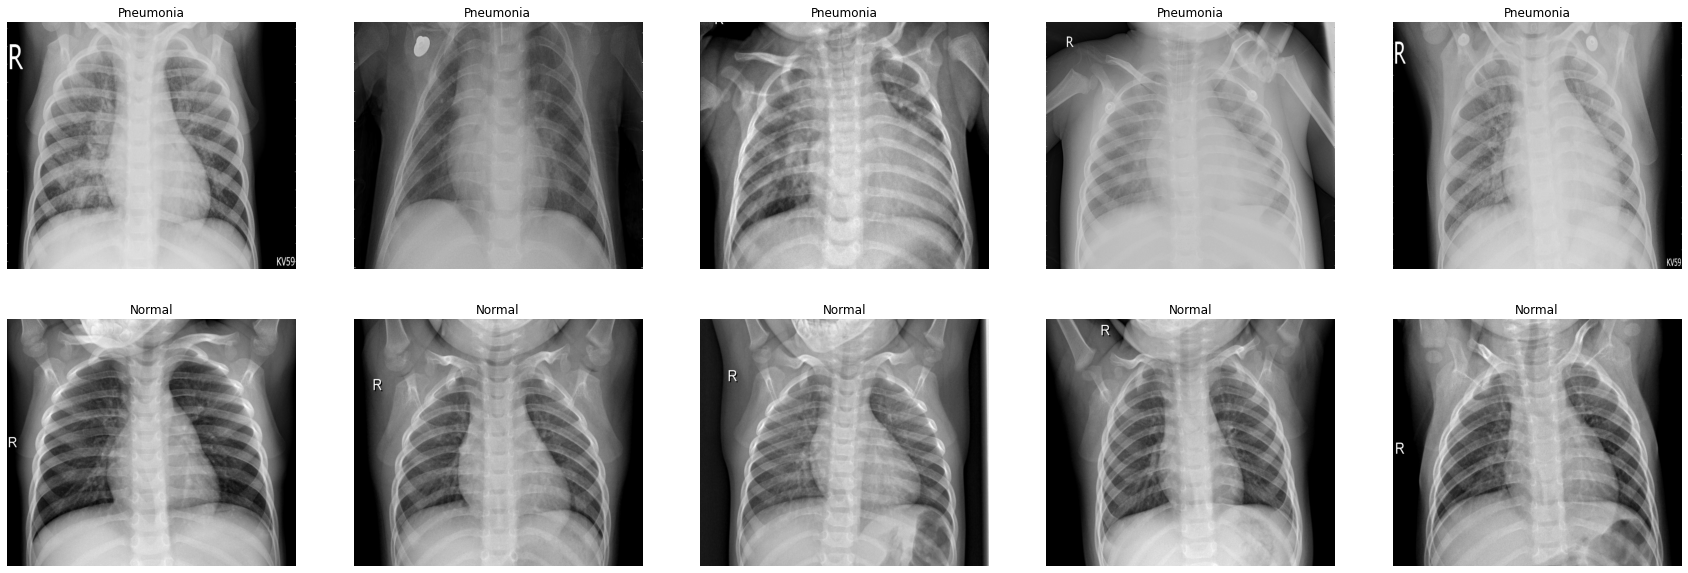

In [119]:
# Get few samples for both the classes
pneumonia_samples = (df_train[df_train['label'] == 1]['image'].iloc[:5]).tolist()
normal_samples = (df_train[df_train['label'] == 0]['image'].iloc[:5]).tolist()

# Concat the data in a single list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5,figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

# Preprocessing

We have multi various sized images. We can't process them without resizing. I resized them into 150x150 so we will have 22500 pixels for each image.

In [123]:
def data_preprocessing(dataset) :
    
    X = np.zeros((1,150,150,1), np.uint8)
    y = np.zeros((1,1), np.uint8)

    for count,ele in enumerate(dataset.iloc[:,0],0) : 
    
        y_temp = dataset.iloc[count,1]
        y = np.vstack((y,y_temp))
        X_temp = cv.imread(str(ele), cv.IMREAD_GRAYSCALE) 
        #print("X_temp shape (1) : {}".format(X_temp.shape))
    
        # We need to reshape our 22500 pixels to (150,150) for each image.
        X_temp = cv.resize(X_temp,(150,150)).reshape(-1,150,150,1)
        #print("X_temp shape (2) : {}".format(X_temp.shape))
        X = np.vstack((X, X_temp))
        #print("X shape : {}".format(X.shape))

    X = X[1:,:]
    y = y[1:,:]
    
    # We need to normalize the data otherwise some of them will perform superiority on others.
    X = X[:,:]/255
    
    return X, y

In [124]:
X_train, y_train = data_preprocessing(dataset = df_train)
print("X_train shape : {}".format(X_train.shape))

# Splitting

So far, we have 500 normal and 500 pneumonia images and labels one after another. We need to mix them to avoid overfitting. Also we will be splitted the data into train and validation.

In [108]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("X_train shape : {}\nX_val shape : {}".format(X_train.shape, X_val.shape))

X_train shape : (900, 150, 150, 1)
X_val shape : (100, 150, 150, 1)


# Visualization 

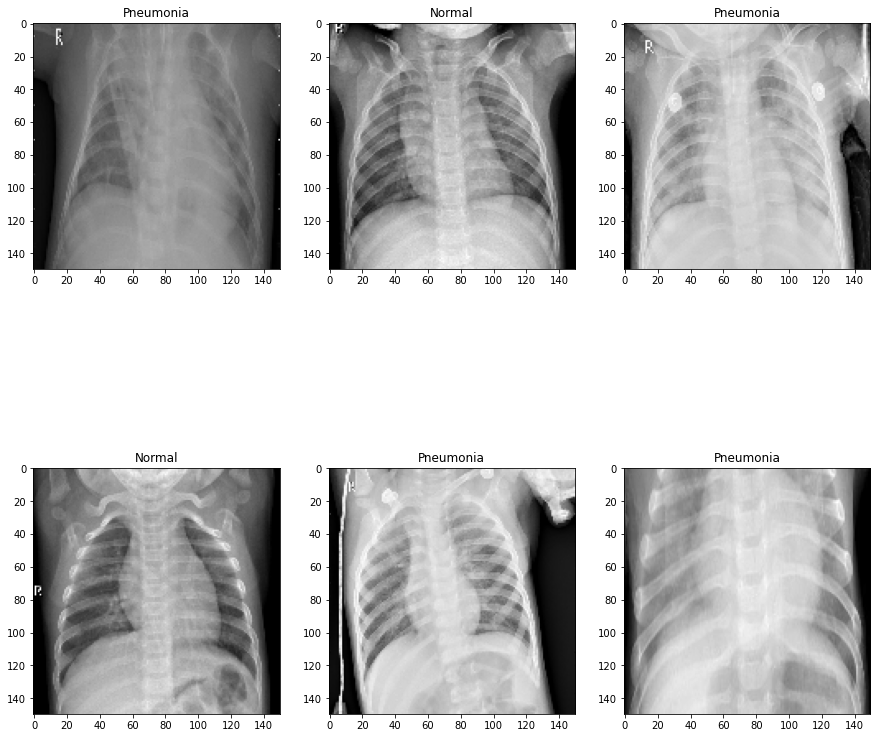

In [109]:
plt.figure(figsize=(15,15))

for count,i in enumerate(range(0,6),231):
    
    plt.subplot(count)
    if y_train[i]==1:
        plt.title("Pneumonia")
        plt.imshow(X_train[i,:].reshape(150,150), 'gray')
        
    elif y_train[i]==0:
        plt.title("Normal")
        plt.imshow(X_train[i,:].reshape(150,150), 'gray')
        
plt.show()        

# Building

Structure of CNN model will be like (Conv2D -> relu -> MaxPool2D -> Dropout) x 2 -> Flatten -> Dense -> Dropout -> Out

Again, CNN will start with "Sequential". Conv2D takes 3D array as input shape so we need to reshape our data. Since I resized my data into (1,10000), 100x100 will be fine as new shape. I will do that reshaping later. I will choose the hyper paramaters such as optimizer,loss function,activation,same as in the ann so we can compare.

In [9]:
#Initialising the CNN
cnn = Sequential()
cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu',input_shape=[150,150,1]))  # 1 is our canal number it is just 1 because we use grayscale data
cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))

#Pooling
cnn.add(MaxPool2D(pool_size=2,strides=2)) #I preffered Max Pooling for this model
cnn.add(Dropout(0.2))

#Second Layer
cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(MaxPool2D(pool_size=2,strides=2))
cnn.add(Dropout(0.2))

#Flattening and bulding ANN

cnn.add(Flatten())
cnn.add(Dense(64, activation = "relu"))
cnn.add(Dense(32, activation = "relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation = "sigmoid")) 

# Compiling

In [10]:
# Now we need to choose loss function, optimizer and compile the model
cnn.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation

Data Augmentation is a process we can make some manipulation on images such as rotating, zoom in,zoom out,shifting etc. It is important to avoid overfitting.

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(X_train)

# Fitting

We will use `fit_generator` method since we did data augmentation.

In [13]:
cnn.fit_generator(datagen.flow(X_train, y_train, batch_size = 20),
                  epochs = 90,
                  validation_data = (X_val,y_val),
                  verbose = 1,
                  steps_per_epoch = len(X_train) // 20)

Epoch 1/90
45/45 [==============================] - 103s 2s/step - loss: 0.6997 - accuracy: 0.4778 - val_loss: 0.6931 - val_accuracy: 0.5300
Epoch 2/90
45/45 [==============================] - 101s 2s/step - loss: 0.6898 - accuracy: 0.5067 - val_loss: 0.6910 - val_accuracy: 0.6600
Epoch 3/90
45/45 [==============================] - 95s 2s/step - loss: 0.6703 - accuracy: 0.6978 - val_loss: 0.6791 - val_accuracy: 0.7300
Epoch 4/90
45/45 [==============================] - 96s 2s/step - loss: 0.6416 - accuracy: 0.7144 - val_loss: 0.6210 - val_accuracy: 0.7300
Epoch 5/90
45/45 [==============================] - 97s 2s/step - loss: 0.6150 - accuracy: 0.7344 - val_loss: 0.5929 - val_accuracy: 0.7400
Epoch 6/90
45/45 [==============================] - 100s 2s/step - loss: 0.6229 - accuracy: 0.7100 - val_loss: 0.6246 - val_accuracy: 0.7400
Epoch 7/90
45/45 [==============================] - 95s 2s/step - loss: 0.5901 - accuracy: 0.7400 - val_loss: 0.5563 - val_accuracy: 0.8400
Epoch 8/90
45/45 

# Predicton

In [14]:
predicted = cnn.predict(X_val)
y_pred = [0 if i < 0.5 else 1 for i in predicted]

# Evaluation

0.94


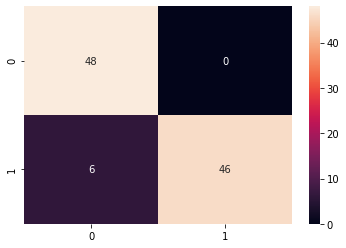

In [15]:
print(accuracy_score(y_val, y_pred))
cm_cnn = confusion_matrix(y_val,y_pred)
sns.heatmap(cm_cnn, annot=True) ;

# Prediction On Test Data

We need to pre process the test data in same way we did before.

In [113]:
df_test = loading_data(train_or_test_set = 'test_set')
X_test, y_test = data_preprocessing(dataset = df_test)

              precision    recall  f1-score   support

         0.0       0.92      0.78      0.84       234
         1.0       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



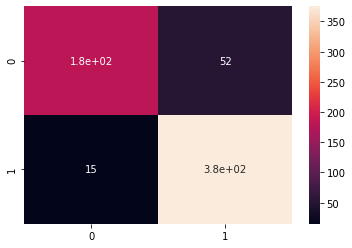

In [115]:
predicted = cnn.predict(X_test)
y_pred = [0 if i < 0.5 else 1 for i in predicted]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True) ;